[✓] Using device: cuda
Found existing tokenizer model: bpe_tokenizer_v1.model
Tokenizer loaded. Vocab size: 10000. Special IDs: UNK=0, BOS=1, EOS=2, PAD=3
Using Padding Token ID: 3
Effective vocabulary size: 10000

Loading and tokenizing datasets...
Loaded 39557 text entries from train.jsonl (out of 39557 lines). Total combined length: 14870901 characters
Tokenized into 3757733 tokens.
Loaded 9890 text entries from test.jsonl (out of 9890 lines). Total combined length: 3733785 characters
Tokenized into 943202 tokens.

Building sequences...
Number of training sequences created: 3757605
Number of validation sequences created: 943074

Creating Dataset objects and DataLoaders...
Train dataset size: 3757605 samples
Validation dataset size: 943074 samples

Initializing models...

===== Processing Model: Transformer =====
Model: Transformer, Trainable Parameters: 5,790,224
--- Starting Training for Transformer ---
Epoch 01/30 | LR: 0.000300 | Train Loss: 4.6639 | Val Loss: 4.6134 | Duration: 

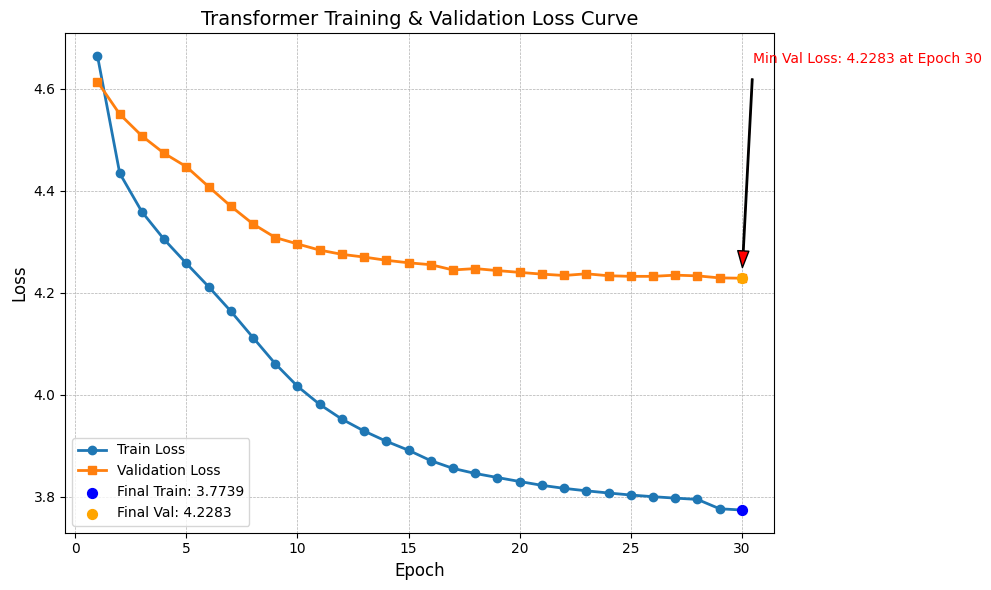


--- Evaluating Final Transformer Model on Validation Set ---
Calculating BLEU score on 50 validation samples...


RuntimeError: The size of tensor a (136) must match the size of tensor b (128) at non-singleton dimension 1

In [ ]:
#!/usr/bin/env python3
"""
Foundational AI Project 2 – Language Modeling with RNNs, LSTMs, and Transformer (Graduate Version)

This script trains three language models (RNN, LSTM, Transformer) for text generation.
It uses a SentencePiece BPE tokenizer (vocab size=10000) to tokenize text from JSONL files,
builds fixed-length sequences via a sliding window approach, and trains the models
using early stopping with a ReduceLROnPlateau learning rate scheduler.
Evaluation metrics include perplexity (exp(cross-entropy loss)), token accuracy,
and BLEU score (computed with nltk on a sample). Sample outputs and loss curves with detailed plots
are generated, and model performance is compared.
Graduate-level requirements such as temperature-based decoding are supported in the prompt methods.
"""

# Standard library imports
import os
import math
import json
import random
import time

# Third-party library imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau # Learning rate scheduler that reduces LR when a metric plateaus
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm  # For BPE tokenization
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # BLEU score computation with smoothing

# --- NLTK Data Check ---
# Ensure the 'punkt' tokenizer data (used by nltk.word_tokenize for BLEU) is available.
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("Downloading NLTK 'punkt' tokenizer data...")
    nltk.download('punkt', quiet=True) # Download quietly

# --- Reproducibility ---
# Set random seeds for Python, NumPy, and PyTorch to ensure reproducible results.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# Ensure reproducibility on CUDA if available (can slightly slow down computation)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# --- Device Selection ---
# Select the appropriate computation device (GPU > MPS > CPU).
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed) # Set seed for all GPUs
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    # Check if MPS (Apple Silicon GPU) is available and functional.
    try:
        # Perform a simple tensor operation on MPS to verify usability.
        torch.ones(1, device="mps")
        device = torch.device("mps")
    except Exception:
        # Fallback to CPU if MPS check fails.
        print("MPS device found but may not be usable. Falling back to CPU.")
        device = torch.device("cpu")
else:
    device = torch.device("cpu")
print(f"[✓] Using device: {device}")

###############################################################################
# Positional Encoding Module (for Transformer)
###############################################################################
class PositionalEncoding(nn.Module):
    """
    Injects positional information into token embeddings using sinusoidal functions.
    This allows the Transformer model, which lacks inherent sequence order awareness,
    to utilize token position information. Based on 'Attention is All You Need'.

    Args:
        embed_dim (int): The embedding dimension (d_model).
        max_len (int): The maximum sequence length for which to precompute encodings.
                       Should be at least as large as the longest sequence length.
        dropout (float): Dropout rate applied after adding positional encodings.
    """
    def __init__(self, embed_dim: int, max_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix for positional encodings: [max_len, embed_dim]
        pos_enc = torch.zeros(max_len, embed_dim)

        # Create position indices: [max_len, 1] (tensor([[0.], [1.], ..., [max_len-1]]))
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the frequencies.
        # Formula: 1 / (10000^(2i / embed_dim))
        # Use log space for numerical stability: exp(-log(10000) * (2i / embed_dim))
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) * -(math.log(10000.0) / embed_dim))

        # Calculate sinusoidal encodings:
        # Even indices (0, 2, 4, ...): PE(pos, 2i) = sin(pos / (10000^(2i / embed_dim)))
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        # Odd indices (1, 3, 5, ...): PE(pos, 2i+1) = cos(pos / (10000^(2i / embed_dim)))
        pos_enc[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension: [1, max_len, embed_dim]
        # This allows easy broadcasting when adding to batch embeddings.
        pos_enc = pos_enc.unsqueeze(0)

        # Register 'pos_enc' as a buffer. Buffers are part of the model's state_dict
        # but are not considered model parameters (not updated by optimizer).
        self.register_buffer("pos_enc", pos_enc)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Adds positional encoding to the input tensor.

        Args:
            x (Tensor): Input tensor of token embeddings.
                        Shape: [batch_size, seq_length, embed_dim].

        Returns:
            Tensor: Output tensor with positional information added.
                    Shape: [batch_size, seq_length, embed_dim].
        """
        # Add positional encoding to the input embeddings.
        # Slice precomputed encodings 'pos_enc' to match the input sequence length (x.size(1)).
        # Shape: [batch_size, seq_length, embed_dim] + [1, seq_length, embed_dim] -> [batch_size, seq_length, embed_dim]
        x = x + self.pos_enc[:, :x.size(1)]

        # Apply dropout for regularization.
        return self.dropout(x)

###############################################################################
# Data Preparation Functions
###############################################################################
def train_tokenizer_if_needed(tokenizer_model_prefix: str = "tokenizer", vocab_size: int = 10000, training_text_file: str = "merged_corpus.txt") -> spm.SentencePieceProcessor:
    """
    Trains a SentencePiece BPE (Byte-Pair Encoding) tokenizer on the provided text file
    if the tokenizer model files (.model, .vocab) do not already exist.

    Args:
        tokenizer_model_prefix (str): The prefix for the output model and vocabulary files.
        vocab_size (int): The target vocabulary size for the tokenizer.
        training_text_file (str): The path to the plain text file used for training the tokenizer.

    Returns:
        spm.SentencePieceProcessor: An instance of the loaded SentencePiece processor.

    Raises:
        FileNotFoundError: If the training text file does not exist and model files are missing.
        Exception: If tokenizer training fails.
    """
    model_path = f"{tokenizer_model_prefix}.model"
    vocab_path = f"{tokenizer_model_prefix}.vocab"

    # Check if both model and vocab files exist.
    if not os.path.exists(model_path) or not os.path.exists(vocab_path):
        print(f"Tokenizer model ('{model_path}' or '{vocab_path}') not found. Training...")
        # Check if the training data file exists.
        if not os.path.exists(training_text_file):
             raise FileNotFoundError(f"Tokenizer training file '{training_text_file}' not found. Cannot train tokenizer.")

        try:
            # Train the SentencePiece model using the specified parameters.
            spm.SentencePieceTrainer.train(
                input=training_text_file,          # Path to the training text file.
                model_prefix=tokenizer_model_prefix, # Prefix for output files (.model, .vocab).
                vocab_size=vocab_size,             # Target size of the vocabulary.
                model_type="bpe",                  # Use Byte-Pair Encoding algorithm.
                character_coverage=1.0,            # Try to cover all characters in the training data.
                # Define IDs for standard special tokens. SentencePiece uses these defaults if not specified.
                # UNK (Unknown): Represents out-of-vocabulary words.
                # BOS (Beginning-of-Sequence): Optional start token.
                # EOS (End-of-Sequence): Marks the end of a sentence or sequence.
                # PAD (Padding): Used to make sequences in a batch the same length.
                unk_id=0,       # Typically ID 0 for <unk>
                bos_id=1,       # Typically ID 1 for <s>
                eos_id=2,       # Typically ID 2 for </s>
                pad_id=3        # Explicitly set PAD ID to 3. If set to -1, PAD is disabled.
            )
            print("Tokenizer training complete.")
        except Exception as e:
            # Handle potential errors during training.
            print(f"Error training tokenizer: {e}")
            # Clean up potentially incomplete model/vocab files if training failed.
            if os.path.exists(model_path): os.remove(model_path)
            if os.path.exists(vocab_path): os.remove(vocab_path)
            raise # Re-raise the exception after cleanup.
    else:
        # If model files exist, skip training.
        print(f"Found existing tokenizer model: {model_path}")

    # Load the trained tokenizer model from the file.
    sp = spm.SentencePieceProcessor(model_file=model_path)
    # Print tokenizer details for verification.
    print(f"Tokenizer loaded. Vocab size: {sp.vocab_size()}. Special IDs: "
          f"UNK={sp.unk_id()}, BOS={sp.bos_id()}, EOS={sp.eos_id()}, PAD={sp.pad_id()}")
    return sp

def load_and_tokenize(file_path: str, sp: spm.SentencePieceProcessor) -> list[int]:
    """
    Loads text data from a JSONL file (each line is a JSON object), extracts "prompt"
    and "completion" fields, combines them, concatenates all entries using the
    tokenizer's EOS token as a separator, and tokenizes the entire text into a single
    list of token IDs.

    Args:
        file_path (str): Path to the JSONL file.
        sp (SentencePieceProcessor): The initialized SentencePiece tokenizer instance.

    Returns:
        list[int]: A flat list of token IDs representing the tokenized content of the file.
    """
    texts = [] # List to hold individual text entries (prompt + completion)
    count = 0  # Counter for total lines processed

    # Read the JSONL file line by line.
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            count += 1
            try:
                # Attempt to parse the line as a JSON object.
                obj = json.loads(line)
            except json.JSONDecodeError:
                # Skip lines that are not valid JSON.
                # print(f"Warning: Skipping invalid JSON line in {file_path} (line {count})")
                continue
            # Extract "prompt" and "completion" fields, defaulting to empty strings if missing.
            prompt = obj.get("prompt", "")
            completion = obj.get("completion", "")
            # Combine prompt and completion, stripping leading/trailing whitespace.
            text = (prompt + " " + completion).strip()
            # Add the combined text to the list if it's not empty.
            if text:
                texts.append(text)

    # --- Determine the EOS token string for separation ---
    eos_id = sp.eos_id() # Get the integer ID for the EOS token.
    eos_string = ""      # Initialize EOS string representation.

    if eos_id is not None and eos_id >= 0: # Check if a valid EOS ID exists.
        try:
            # Decode the EOS ID back to its string representation (e.g., "</s>").
            # Need to pass it as a list to decode.
            eos_string = sp.decode([eos_id])
            # Handle cases where the decoded special token might be empty or unexpected.
            # Use common default '</s>' if ID is 2 and decode is empty.
            if not eos_string and eos_id == 2:
                eos_string = "</s>"
            # If still empty after checks, issue a warning and fallback to newline.
            if not eos_string:
                 print(f"Warning: Decoded EOS token ID {eos_id} resulted in an empty string. Using newline fallback.")
                 eos_string = "\n"
        except Exception as e:
             # Handle errors during decoding and fallback to newline.
             print(f"Warning: Could not decode EOS token ID {eos_id}. Error: {e}. Using newline fallback.")
             eos_string = "\n"
    else:
        # If no EOS token ID is defined in the tokenizer, use newline as separator.
        print("Warning: EOS token ID not found in tokenizer. Using newline as separator.")
        eos_string = "\n"

    # Define the separator string, adding newlines around the EOS token for clarity.
    # Strip potential whitespace from the decoded token itself.
    separator = f"\n{eos_string.strip()}\n"

    # Join all extracted text entries into a single large string using the separator.
    # This creates one continuous corpus for sequence building.
    combined = separator.join(texts)
    # --- End of EOS handling and text combination ---

    print(f"Loaded {len(texts)} text entries from {file_path} (out of {count} lines). "
          f"Total combined length: {len(combined)} characters")

    # Tokenize the entire combined text into a list of integer IDs.
    token_ids = sp.encode(combined, out_type=int)
    print(f"Tokenized into {len(token_ids)} tokens.")
    return token_ids

def build_sequences(token_ids: list[int], seq_length: int) -> list[list[int]]:
    """
    Creates overlapping sequences of a fixed length from a flat list of token IDs
    using a sliding window approach. Each sequence has length `seq_length + 1`
    to facilitate creating input/target pairs (input = seq[:-1], target = seq[1:]).

    Args:
        token_ids (list[int]): The flat list of token IDs from the tokenized corpus.
        seq_length (int): The desired length of the *input* sequences. The generated
                          sequences will have length `seq_length + 1`.

    Returns:
        list[list[int]]: A list of sequences, where each sequence is a list of token IDs
                         of length `seq_length + 1`. Returns an empty list if no
                         valid sequences can be created.

    Raises:
        ValueError: If `seq_length` is not positive.
    """
    # Validate seq_length.
    if seq_length <= 0:
        raise ValueError("seq_length must be positive.")
    # Check if there are enough tokens to form even one sequence.
    if len(token_ids) <= seq_length:
         print(f"Warning: Token list length ({len(token_ids)}) is not greater than seq_length ({seq_length}). "
               "Cannot generate sequences.")
         return []

    # Use a list comprehension for efficient sliding window creation.
    # For each starting index `i`, take a slice of length `seq_length + 1`.
    # Stop when the slice would go beyond the end of the `token_ids` list.
    sequences = [token_ids[i : i + seq_length + 1] for i in range(len(token_ids) - seq_length)]
    return sequences

###############################################################################
# Custom Dataset Class for Language Modeling
###############################################################################
class LanguageModelDataset(Dataset):
    """
    A PyTorch Dataset for language modeling. It takes a list of token sequences
    (each of length `seq_length + 1`) and provides input/target pairs for training.
    Each sample retrieved by `__getitem__` is a tuple (input_tokens, target_tokens),
    where `target_tokens` are the `input_tokens` shifted one position to the right.
    """
    def __init__(self, sequences: list[list[int]], seq_length: int):
        """
        Initializes the dataset.

        Args:
            sequences (list[list[int]]): A list of token sequences, where each sequence
                                         is expected to have length `seq_length + 1`.
            seq_length (int): The length of the input sequences (targets will also have this length).
        """
        # Create input/target pairs: input = sequence[:-1], target = sequence[1:]
        # Include a check to filter out any sequences that might not have the exact required length.
        # This should ideally not happen if `build_sequences` is used correctly, but acts as a safeguard.
        self.samples = [(seq[:-1], seq[1:]) for seq in sequences if len(seq) == seq_length + 1]

        # Report if any sequences were filtered out due to incorrect length.
        if len(self.samples) < len(sequences):
             print(f"Warning: Filtered out {len(sequences) - len(self.samples)} sequences due to "
                   f"incorrect length (expected {seq_length + 1}).")

    def __len__(self) -> int:
        """Returns the total number of samples (input/target pairs) in the dataset."""
        return len(self.samples)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves the sample (input/target pair) at the given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing:
                - input_tokens (torch.Tensor): Tensor of input token IDs (dtype=torch.long).
                - target_tokens (torch.Tensor): Tensor of target token IDs (dtype=torch.long).
        """
        inp_ids, target_ids = self.samples[idx]
        # Convert the lists of token IDs to PyTorch tensors of type long.
        return torch.tensor(inp_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)

###############################################################################
# Text Generation Function and Model Definitions
###############################################################################
def generate_text(model: nn.Module,
                  tokenizer: spm.SentencePieceProcessor,
                  prompt_text: str,
                  max_length: int = 128,
                  temperature: float = 1.0) -> str:
    """
    Generates text autoregressively starting from a given prompt using the provided model.

    Supports temperature-based sampling for controlling randomness.

    Args:
        model (nn.Module): The trained language model (RNN, LSTM, or Transformer).
        tokenizer (SentencePieceProcessor): The tokenizer used for encoding/decoding.
        prompt_text (str): The initial text to seed the generation.
        max_length (int): The maximum number of *new* tokens to generate after the prompt.
        temperature (float): Controls the randomness of sampling.
                             - temperature=0 (or close to 0): Greedy decoding (always pick the most likely token).
                             - temperature=1.0: Standard sampling from the model's predicted probabilities.
                             - temperature > 1.0: Increases randomness, makes less likely tokens more probable.
                             - 0 < temperature < 1.0: Decreases randomness, favors more likely tokens.

    Returns:
        str: The generated text, including the original prompt.
    """
    model.eval()
    model_device = next(model.parameters()).device

    # initial tokens
    generated = tokenizer.encode(prompt_text,
                                 out_type=int,
                                 add_bos=False,
                                 add_eos=False).copy()

    eos_token_id = tokenizer.eos_id()
    if eos_token_id is None or eos_token_id < 0:
        eos_token_id = -1

    # get the model's max_seq_length if it exists
    max_allowed = getattr(model, "max_seq_length", None)

    with torch.no_grad():
        for _ in range(max_length):
            # TRUNCATE here:
            seq = generated
            if max_allowed and len(seq) > max_allowed:
                seq = seq[-max_allowed:]

            input_ids = torch.tensor([seq], dtype=torch.long, device=model_device)
            logits = model(input_ids)
            next_logits = logits[0, -1, :]

            if temperature < 1e-5:
                next_token = torch.argmax(next_logits).item()
            else:
                probs = torch.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()

            if next_token == eos_token_id:
                break
            generated.append(next_token)

    return tokenizer.decode(generated)


class RNNLanguageModel(nn.Module):
    """
    A simple language model based on vanilla Recurrent Neural Networks (RNNs).

    Architecture:
        1. Embedding Layer: Maps input token IDs to dense vectors.
        2. Dropout Layer: Applied after embedding.
        3. RNN Layer(s): Processes the sequence of embeddings.
        4. Dropout Layer: Applied after RNN output.
        5. Linear Layer (FC): Maps RNN hidden states to vocabulary logits.

    Args:
        vocab_size (int): Size of the vocabulary.
        embed_dim (int): Dimension of token embeddings.
        hidden_dim (int): Dimension of RNN hidden states.
        num_layers (int): Number of stacked RNN layers.
        dropout (float): Dropout probability for dropout layers.
    """
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_layers: int, dropout: float = 0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # `batch_first=True`: Input/output tensors have shape [batch, seq, feature].
        # Dropout is applied between RNN layers if num_layers > 1.
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # Fully connected layer to project RNN output to vocabulary size.
        self.fc = nn.Linear(hidden_dim, vocab_size)
        # Separate dropout layer applied after embedding and RNN output.
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass of the RNN model.

        Args:
            x (torch.Tensor): Input tensor of token IDs. Shape: [batch_size, seq_length].

        Returns:
            torch.Tensor: Output tensor of logits. Shape: [batch_size, seq_length, vocab_size].
        """
        # 1. Embeddings
        # Shape: [batch_size, seq_length] -> [batch_size, seq_length, embed_dim]
        embeds = self.dropout_layer(self.embedding(x))

        # 2. RNN
        # `output` contains hidden states for all time steps. Shape: [batch, seq_length, hidden_dim]
        # `_` holds the final hidden state (h_n). We don't need it directly for logits.
        output, _ = self.rnn(embeds)
        # Apply dropout to the RNN output sequence.
        output = self.dropout_layer(output)

        # 3. Fully Connected Layer
        # Project hidden states to vocabulary logits.
        # Shape: [batch, seq_length, hidden_dim] -> [batch, seq_length, vocab_size]
        logits = self.fc(output)
        return logits

    def prompt(self, tokenizer: spm.SentencePieceProcessor, prompt_text: str, max_length: int = 128, temperature: float = 1.0) -> str:
        """ Convenience method to generate text using this model. """
        return generate_text(self, tokenizer, prompt_text, max_length, temperature)

class LSTMLanguageModel(nn.Module):
    """
    A language model based on Long Short-Term Memory (LSTM) networks.

    Architecture is similar to RNNLanguageModel, but uses LSTM layers which are
    generally better at capturing long-range dependencies.

    Args:
        vocab_size (int): Size of the vocabulary.
        embed_dim (int): Dimension of token embeddings.
        hidden_dim (int): Dimension of LSTM hidden and cell states.
        num_layers (int): Number of stacked LSTM layers.
        dropout (float): Dropout probability for dropout layers and between LSTM layers.
    """
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_layers: int, dropout: float = 0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # `batch_first=True`: Input/output tensors have shape [batch, seq, feature].
        # Dropout is applied between LSTM layers if num_layers > 1.
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # Fully connected layer to project LSTM output to vocabulary size.
        self.fc = nn.Linear(hidden_dim, vocab_size)
        # Separate dropout layer applied after embedding and LSTM output.
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass of the LSTM model.

        Args:
            x (torch.Tensor): Input tensor of token IDs. Shape: [batch_size, seq_length].

        Returns:
            torch.Tensor: Output tensor of logits. Shape: [batch_size, seq_length, vocab_size].
        """
        # 1. Embeddings
        # Shape: [batch_size, seq_length] -> [batch_size, seq_length, embed_dim]
        embeds = self.dropout_layer(self.embedding(x))

        # 2. LSTM
        # `output` contains hidden states for all time steps. Shape: [batch, seq_length, hidden_dim]
        # `_` holds the final hidden state (h_n) and cell state (c_n). We don't need them directly for logits.
        output, _ = self.lstm(embeds)
        # Apply dropout to the LSTM output sequence.
        output = self.dropout_layer(output)

        # 3. Fully Connected Layer
        # Project hidden states to vocabulary logits.
        # Shape: [batch, seq_length, hidden_dim] -> [batch, seq_length, vocab_size]
        logits = self.fc(output)
        return logits

    def prompt(self, tokenizer: spm.SentencePieceProcessor, prompt_text: str, max_length: int = 128, temperature: float = 1.0) -> str:
        """ Convenience method to generate text using this model. """
        return generate_text(self, tokenizer, prompt_text, max_length, temperature)

class TransformerLanguageModel(nn.Module):
    """
    A language model based on the Transformer architecture (specifically, the Encoder part).
    Uses self-attention mechanism to capture dependencies between tokens, potentially
    handling long-range dependencies better than RNNs/LSTMs. Includes positional encoding
    and a causal mask for autoregressive generation.

    Architecture:
        1. Embedding Layer: Maps token IDs to vectors. Embeddings are scaled.
        2. Positional Encoding: Adds positional information to embeddings.
        3. Transformer Encoder: Consists of multiple Transformer Encoder Layers.
           - Each layer has Multi-Head Self-Attention and a Feed-Forward Network.
           - A causal mask is applied to ensure autoregressive property (attend only to past tokens).
        4. Linear Layer (FC): Maps Transformer output to vocabulary logits.

    Args:
        vocab_size (int): Size of the vocabulary.
        embed_dim (int): Dimension of token embeddings (d_model).
        num_heads (int): Number of attention heads in Multi-Head Self-Attention. Must divide embed_dim.
        hidden_dim (int): Dimension of the feed-forward network inside Transformer layers.
        num_layers (int): Number of stacked Transformer Encoder layers.
        max_seq_length (int): Maximum sequence length the model can handle (used for causal mask).
        dropout (float): Dropout probability used in positional encoding and Transformer layers.
    """
    def __init__(self, vocab_size: int, embed_dim: int, num_heads: int, hidden_dim: int, num_layers: int, max_seq_length: int, dropout: float = 0.2):
        super().__init__()
        # Ensure embedding dimension is divisible by the number of heads.
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_seq_length, dropout=dropout)

        # Define a single Transformer Encoder layer.
        # `batch_first=True` ensures input/output shapes are [batch, seq, feature].
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=hidden_dim, dropout=dropout,
                                                   batch_first=True) # Crucial for shape consistency
        # Stack multiple encoder layers.
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected layer to project Transformer output to vocabulary size.
        self.fc = nn.Linear(embed_dim, vocab_size)

        # Store embedding dimension and max sequence length for later use.
        self.embed_dim = embed_dim
        self.max_seq_length = max_seq_length

        # --- Causal Mask ---
        # Generate and register a causal (subsequent) mask. This prevents attention
        # to future positions, which is essential for autoregressive language modeling.
        # The mask shape will be [max_seq_length, max_seq_length].
        self.register_buffer('causal_mask', self._generate_square_subsequent_mask(max_seq_length))

    def _generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        """
        Generates a square causal mask of size [sz, sz].
        Masked positions (future tokens) are filled with float('-inf'),
        unmasked positions (current and past tokens) are filled with float(0.0).
        The Transformer layer adds this mask to the attention scores before softmax.
        """
        # Create an upper triangle matrix of 1s.
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        # Fill with -inf where mask is 0 (future positions), and 0.0 where mask is 1 (current/past).
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass of the Transformer model.

        Args:
            x (torch.Tensor): Input tensor of token IDs. Shape: [batch_size, seq_length].

        Returns:
            torch.Tensor: Output tensor of logits. Shape: [batch_size, seq_length, vocab_size].
        """
        # Get the actual sequence length from the input batch.
        seq_len = x.size(1)

        # --- Prepare Mask ---
        # Select the appropriate part of the precomputed causal mask for the current sequence length.
        # The mask needs to be on the same device as the input tensor `x`.
        # Shape required by TransformerEncoder: [seq_len, seq_len]
        current_mask = self.causal_mask[:seq_len, :seq_len].to(x.device)

        # --- Embeddings and Positional Encoding ---
        # Convert token IDs to embeddings. Shape: [batch, seq_len] -> [batch, seq_len, embed_dim]
        # Scale embeddings by sqrt(embed_dim) as suggested in the 'Attention is All You Need' paper.
        embeds = self.embedding(x) * math.sqrt(self.embed_dim)
        # Add positional encodings. Shape remains [batch, seq_len, embed_dim].
        encoded = self.pos_encoder(embeds)

        # --- Transformer Encoder ---
        # Pass the encoded sequence through the Transformer encoder layers.
        # The `mask` argument ensures causal attention.
        # Input shape (due to batch_first=True): [batch, seq_len, embed_dim]
        # Output shape: [batch, seq_len, embed_dim]
        transformer_out = self.transformer_encoder(encoded, mask=current_mask)

        # --- Fully Connected Layer ---
        # Project Transformer output to vocabulary logits.
        # Shape: [batch, seq_len, embed_dim] -> [batch, seq_len, vocab_size]
        logits = self.fc(transformer_out)
        return logits

    def prompt(self, tokenizer: spm.SentencePieceProcessor, prompt_text: str, max_length: int = 128, temperature: float = 1.0) -> str:
        """ Convenience method to generate text using this model. """
        # The forward pass already incorporates the causal mask, so generate_text works correctly.
        return generate_text(self, tokenizer, prompt_text, max_length, temperature)

###############################################################################
# Training, Evaluation, and Plotting Functions
###############################################################################
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, num_epochs: int,
                criterion: nn.Module, optimizer: optim.Optimizer, scheduler: ReduceLROnPlateau,
                device: torch.device, patience: int = 5, model_name: str = "Model") -> tuple[list, list, float]:
    """
    Trains the language model using the provided data loaders and hyperparameters.
    Implements mini-batch gradient descent, gradient clipping, ReduceLROnPlateau
    learning rate scheduling, and early stopping based on validation loss.

    Args:
        model (nn.Module): The language model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        num_epochs (int): The maximum number of epochs to train for.
        criterion (nn.Module): The loss function (e.g., CrossEntropyLoss).
        optimizer (optim.Optimizer): The optimizer (e.g., AdamW).
        scheduler (ReduceLROnPlateau): The learning rate scheduler.
        device (torch.device): The device (CPU/GPU) to train on.
        patience (int): Number of epochs to wait for validation loss improvement before stopping early.
        model_name (str): Name of the model (used for logging).

    Returns:
        tuple[list, list, float]: A tuple containing:
            - train_losses (list): List of average training losses per epoch.
            - val_losses (list): List of average validation losses per epoch.
            - total_training_time (float): Total time taken for training in seconds.
    """
    # Move the model to the specified device.
    model.to(device)

    # Lists to store loss values for plotting.
    train_losses, val_losses = [], []

    # Variables for early stopping.
    best_val_loss = float('inf') # Initialize with infinity; lower is better.
    best_model_state = None      # To store the state_dict of the best model.
    epochs_no_improve = 0        # Counter for epochs without validation loss improvement.

    print(f"--- Starting Training for {model_name} ---")
    total_start_time = time.time()

    # --- Training Loop ---
    for epoch in range(1, num_epochs + 1):
        # --- Training Phase ---
        model.train() # Set the model to training mode (enables dropout, etc.).
        total_train_loss = 0.0
        num_batches = 0
        epoch_start = time.time()

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Move batch data to the target device.
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients accumulated from the previous batch.
            optimizer.zero_grad()

            # Forward pass: Get model predictions (logits).
            # Shape: [batch, seq_length, vocab_size]
            outputs = model(inputs)

            # Calculate the loss.
            # Reshape outputs and targets for CrossEntropyLoss:
            # Outputs: [batch * seq_length, vocab_size]
            # Targets: [batch * seq_length]
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            # Check for NaN loss, which can indicate instability.
            if torch.isnan(loss):
                print(f"Warning: NaN loss detected at epoch {epoch}, batch {batch_idx}. Skipping batch update.")
                # Consider logging more details or stopping if NaNs persist.
                continue # Skip backward pass and optimizer step for this batch.

            # Backward pass: Compute gradients of the loss w.r.t. model parameters.
            loss.backward()

            # Gradient Clipping: Prevent exploding gradients by clipping the norm of gradients.
            # Helps stabilize training, especially with RNNs/LSTMs.
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update model parameters using the computed gradients.
            optimizer.step()

            # Accumulate loss for averaging later.
            total_train_loss += loss.item()
            num_batches += 1

            # Optional: Log progress within an epoch.
            # if (batch_idx + 1) % 100 == 0:
            #     print(f"  Epoch {epoch}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Calculate average training loss for the epoch.
        if num_batches == 0:
             print("Warning: No batches processed in training epoch {epoch}. Check data loader.")
             avg_train_loss = 0.0
        else:
            avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)

        # --- Validation Phase ---
        model.eval() # Set the model to evaluation mode (disables dropout, etc.).
        total_val_loss = 0.0
        num_val_batches = 0
        with torch.no_grad(): # Disable gradient calculations during validation.
            for inputs, targets in val_loader:
                # Move batch data to the target device.
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass.
                outputs = model(inputs)

                # Calculate loss.
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

                # Check for NaN loss during validation.
                if torch.isnan(loss):
                     print(f"Warning: NaN loss detected during validation epoch {epoch}. Skipping batch contribution.")
                     continue

                total_val_loss += loss.item()
                num_val_batches += 1

        # Calculate average validation loss for the epoch.
        if num_val_batches == 0:
            print(f"Warning: No batches processed in validation epoch {epoch}. Check validation loader.")
            avg_val_loss = float('inf') # Assign infinity if no validation batches.
        else:
            avg_val_loss = total_val_loss / num_val_batches
        val_losses.append(avg_val_loss)

        epoch_duration = time.time() - epoch_start
        # Get the current learning rate from the optimizer.
        current_lr = optimizer.param_groups[0]['lr']

        # Print epoch summary.
        print(f"Epoch {epoch:02d}/{num_epochs} | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Duration: {epoch_duration:.2f}s")

        # --- Learning Rate Scheduling ---
        # Step the scheduler based on the average validation loss.
        # ReduceLROnPlateau will decrease LR if `avg_val_loss` hasn't improved for `scheduler.patience` epochs.
        scheduler.step(avg_val_loss)

        # --- Early Stopping Logic ---
        if avg_val_loss < best_val_loss:
            # Validation loss improved.
            best_val_loss = avg_val_loss
            epochs_no_improve = 0 # Reset the counter.
            # Save the model state dictionary of the best performing model so far.
            # Clone tensors to CPU to avoid GPU memory issues when loading later.
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f"  New best validation loss: {best_val_loss:.4f}. Saving model state.")
            # Optional: Save the best model checkpoint to disk immediately.
            # torch.save(best_model_state, f"{model_name}_best_checkpoint.pt")
        else:
            # Validation loss did not improve.
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")
            # Check if patience limit is reached.
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs due to no improvement for {patience} epochs.")
                # Load the best model state if it was saved.
                if best_model_state:
                    print("Restoring best model state...")
                    # Ensure the model is on the correct device before loading state dict keys might need mapping if device changed
                    model.load_state_dict(best_model_state)
                else:
                    # This case should ideally not happen if training ran for at least one epoch where loss improved.
                    print("Warning: Early stopping triggered, but no best model state was saved (potential issue).")
                break # Exit the training loop.

    # --- End of Training Loop ---
    total_training_time = time.time() - total_start_time
    print(f"--- Finished Training for {model_name} ---")
    print(f"Total Training Time: {total_training_time:.2f} seconds")

    # If early stopping was triggered, ensure the best model state is loaded before returning.
    # This check handles the case where training finishes exactly on the patience limit.
    if epochs_no_improve >= patience and best_model_state:
        # Check if the current model state is already the best one (it should be if restored in the loop)
        # This load is potentially redundant but safe.
        model.load_state_dict(best_model_state)
        print("Ensured best model state is loaded after early stopping.")

    return train_losses, val_losses, total_training_time


def evaluate_model(model: nn.Module, data_loader: DataLoader, criterion: nn.Module, device: torch.device) -> float:
    """
    Evaluates the model's performance on a given dataset (e.g., validation or test set).

    Args:
        model (nn.Module): The trained language model.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        criterion (nn.Module): The loss function used during training.
        device (torch.device): The device (CPU/GPU) to run evaluation on.

    Returns:
        float: The average loss over the entire dataset. Returns float('inf') if evaluation fails.
    """
    model.eval() # Set the model to evaluation mode.
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad(): # Disable gradient calculations.
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Reshape for loss calculation.
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            # Accumulate loss if it's valid.
            if not torch.isnan(loss):
                total_loss += loss.item()
                num_batches += 1
            else:
                 print("Warning: NaN loss encountered during final evaluation.")

    # Calculate average loss.
    if num_batches == 0:
        print("Error: No batches processed during evaluation. Check data loader.")
        return float('inf') # Indicate error or empty dataset.

    return total_loss / num_batches

def compute_perplexity(loss: float) -> float:
    """
    Calculates perplexity from the average cross-entropy loss.
    Perplexity = exp(average_loss). Lower perplexity indicates a better model fit.

    Args:
        loss (float): The average cross-entropy loss.

    Returns:
        float: The calculated perplexity. Returns float('inf') if loss is invalid or too large.
    """
    # Handle invalid loss values.
    if loss is None or loss == float('inf') or loss < 0:
        return float('inf')
    try:
        # Calculate perplexity using the exponential function.
        perplexity = math.exp(loss)
        return perplexity
    except OverflowError:
        # Handle cases where the loss is extremely large, causing exp() to overflow.
        print(f"Warning: Loss value {loss} too large, resulting in perplexity overflow.")
        return float('inf')

def compute_token_accuracy(model: nn.Module, data_loader: DataLoader, device: torch.device) -> float:
    """
    Computes the token-level accuracy of the model on a given dataset.
    Accuracy = (Number of correctly predicted tokens) / (Total number of tokens).

    Args:
        model (nn.Module): The trained language model.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): The device (CPU/GPU) to run evaluation on.

    Returns:
        float: The token accuracy (between 0.0 and 1.0).
    """
    model.eval() # Set the model to evaluation mode.
    correct = 0 # Counter for correctly predicted tokens.
    total = 0   # Counter for total tokens evaluated.
    with torch.no_grad(): # Disable gradient calculations.
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Get model logits. Shape: [batch, seq_len, vocab_size]
            outputs = model(inputs)
            # Get the index of the highest logit for each position (predicted token ID).
            # Shape: [batch, seq_len]
            predictions = torch.argmax(outputs, dim=-1)
            # Compare predictions with the actual target tokens element-wise.
            # Sum up the number of correct predictions in the batch.
            correct += (predictions == targets).sum().item()
            # Add the total number of tokens in the batch targets to the total count.
            total += targets.numel()

    # Calculate accuracy, handling the case of zero total tokens.
    if total == 0:
        print("Warning: Zero tokens found in accuracy calculation. Check data loader.")
        return 0.0
    return correct / total

def compute_bleu(reference: str, candidate: str) -> float:
    """
    Computes the BLEU (Bilingual Evaluation Understudy) score between a candidate
    (generated) sentence and a reference sentence using NLTK.

    Note: BLEU is primarily designed for machine translation and measures n-gram precision.
    Its applicability to open-ended text generation can be limited, but it provides
    a rough measure of lexical overlap.

    Args:
        reference (str): The ground truth sentence (target).
        candidate (str): The generated sentence (prediction).

    Returns:
        float: The BLEU score (typically between 0 and 1). Returns 0.0 if candidate
               or reference is empty or if an error occurs.
    """
    # Return 0 if either string is empty, as BLEU requires content.
    if not candidate or not reference:
        return 0.0

    # Use a smoothing function (Chen & Cherry method 1) to handle cases where
    # higher-order n-grams (e.g., 4-grams) might not appear in the candidate,
    # preventing a score of 0 just because of short sentences or lack of overlap.
    chencherry = SmoothingFunction()

    try:
        # Tokenize the reference and candidate sentences using NLTK's word tokenizer.
        # `sentence_bleu` expects references as a list of lists of tokens.
        ref_tokens = [nltk.word_tokenize(reference.lower())] # Use lowercase for case-insensitive comparison
        cand_tokens = nltk.word_tokenize(candidate.lower())

        # Calculate BLEU score (defaults to BLEU-4, considering 1 to 4-grams).
        bleu = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=chencherry.method1)
    except Exception as e:
        # Catch potential errors during tokenization or BLEU calculation.
        print(f"Warning: Could not compute BLEU score. Error: {e}")
        # Print truncated versions for debugging.
        print(f"  Reference (truncated): '{reference[:100]}...'")
        print(f"  Candidate (truncated): '{candidate[:100]}...'")
        bleu = 0.0 # Return 0.0 on error.
    return bleu

def plot_loss_curve(train_losses: list[float], val_losses: list[float], model_name: str):
    """
    Plots the training and validation loss curves over epochs and saves the plot to a file.
    Includes annotations for minimum validation loss and final loss values.

    Args:
        train_losses (list[float]): List of average training losses per epoch.
        val_losses (list[float]): List of average validation losses per epoch.
        model_name (str): Name of the model (used for title and filename).
    """
    plt.figure(figsize=(10, 6)) # Set figure size.
    epochs = range(1, len(train_losses) + 1) # X-axis values (epochs).

    # Plot training and validation losses.
    plt.plot(epochs, train_losses, label="Train Loss", marker='o', linestyle='-', linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss", marker='s', linestyle='-', linewidth=2)

    # Add labels and title.
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(f"{model_name} Training & Validation Loss Curve", fontsize=14)

    # Add legend.
    plt.legend(fontsize=12)

    # Add grid for better readability.
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Annotations ---
    # Find minimum validation loss and the epoch it occurred at.
    if val_losses: # Ensure val_losses is not empty.
        min_val_loss = min(val_losses)
        min_val_epoch = val_losses.index(min_val_loss) + 1 # Add 1 for 1-based epoch indexing.
        # Add an annotation arrow pointing to the minimum validation loss point.
        plt.annotate(f"Min Val Loss: {min_val_loss:.4f} at Epoch {min_val_epoch}",
                     xy=(min_val_epoch, min_val_loss), # Point coordinates
                     xytext=(min_val_epoch + 0.5, min_val_loss + 0.1 * min_val_loss), # Text position (offset)
                     arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=8), # Arrow style
                     fontsize=10, color='red')

    # Annotate final loss values at the last epoch.
    if len(epochs) > 0:
        final_epoch = epochs[-1]
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]
        # Use scatter points to highlight the final values.
        # `zorder=5` ensures points are plotted on top of lines.
        plt.scatter(final_epoch, final_train_loss, color='blue', s=50, zorder=5,
                    label=f"Final Train: {final_train_loss:.4f}")
        plt.scatter(final_epoch, final_val_loss, color='orange', s=50, zorder=5,
                    label=f"Final Val: {final_val_loss:.4f}")
        plt.legend() # Update legend to include scatter point labels.

    # Adjust layout to prevent labels from overlapping.
    plt.tight_layout()

    # Save the plot to a file.
    filename = f"{model_name}_loss_curve.png"
    plt.savefig(filename, dpi=300) # Save with high resolution.
    print(f"Loss curve saved as {filename}")

    # Display the plot.
    plt.show()

###############################################################################
# Main Training and Evaluation Pipeline
###############################################################################
def main():
    """
    Orchestrates the entire process:
    1. Sets up hyperparameters and file paths.
    2. Prepares the tokenizer (trains if necessary).
    3. Loads and preprocesses data (tokenization, sequence building).
    4. Creates DataLoaders.
    5. Initializes RNN, LSTM, and Transformer models.
    6. Trains each model with evaluation, LR scheduling, and early stopping.
    7. Calculates final metrics (perplexity, accuracy, BLEU).
    8. Generates sample text from each model.
    9. Saves trained models.
    10. Compares model performance using tables and plots.
    """
    global_start = time.time() # Record start time for total duration.

        # ------------------ Hyperparameters ------------------
    # These values can be tuned based on the specific dataset, task, and available hardware.
    vocab_size = 10000         # Target vocabulary size for the BPE tokenizer.
    embed_dim = 256            # Dimensionality of token embeddings.
    hidden_dim = 128           # Hidden dimension for RNN/LSTM and feed-forward layer in Transformer.
                               # Increased from original script for potentially more capacity.
    num_layers = 2             # Number of layers in RNN/LSTM/Transformer encoder stacks.
    num_heads = 8              # Number of attention heads in Transformer (must divide embed_dim).
    max_seq_length = 512       # Maximum length of input sequences fed to the models.
    batch_size = 128            # Number of sequences per training batch. Smaller batches can sometimes help generalization
                               # and reduce memory usage, but may slow down training.
    num_epochs = 30            # Maximum number of training epochs. Early stopping might finish sooner.
    learning_rate = 3e-4       # Initial learning rate for the AdamW optimizer.
    dropout_rate = 0.2         # Dropout rate for regularization in models.
    weight_decay = 0.01        # Weight decay (L2 regularization) for the AdamW optimizer. Helps prevent overfitting.
    # Note: pad_token_id is determined dynamically from the tokenizer later.

    # ReduceLROnPlateau Scheduler Parameters
    lr_patience = 2            # Number of epochs with no improvement in validation loss before reducing LR.
    lr_factor = 0.5            # Factor by which the learning rate will be reduced (new_lr = lr * factor).

    # Early Stopping Parameters
    early_stopping_patience = 5 # Number of epochs with no improvement in validation loss before stopping training.

    # ------------------ File Paths ------------------
    train_file = "train.jsonl"                  # Path to the training data JSONL file.
    test_file = "test.jsonl"                    # Path to the validation/test data JSONL file.
    tokenizer_model_prefix = "bpe_tokenizer_v1" # Prefix for saving/loading the tokenizer model.
    tokenizer_training_file = "merged_corpus.txt" # Path to the text file used FOR training the tokenizer.
                                                  # This file will be created if it doesn't exist.

    # --- File Existence Checks ---
    if not os.path.exists(train_file):
        raise FileNotFoundError(f"Training data file not found: {train_file}")
    if not os.path.exists(test_file):
        raise FileNotFoundError(f"Validation/Test data file not found: {test_file}")

    # ------------------ Prepare Training Text for Tokenizer (if needed) ------------------
    # Check if the tokenizer model already exists. If not, prepare the training text file.
    if not os.path.exists(f"{tokenizer_model_prefix}.model"):
        # If the consolidated training text file doesn't exist, create it from the train_file.
        if not os.path.exists(tokenizer_training_file):
            print(f"Creating combined text file for tokenizer training: {tokenizer_training_file}")
            texts = []
            # Read the training JSONL file.
            with open(train_file, "r", encoding="utf-8") as f_in:
                for line in f_in:
                    try:
                        # Parse each line as JSON.
                        obj = json.loads(line)
                        # Extract prompt and completion.
                        prompt = obj.get("prompt", "")
                        completion = obj.get("completion", "")
                        # Combine and strip whitespace.
                        text = (prompt + " " + completion).strip()
                        # Add non-empty text to the list.
                        if text:
                            texts.append(text)
                    except json.JSONDecodeError:
                        # Skip invalid JSON lines.
                        continue
            # Join all texts with newlines and write to the tokenizer training file.
            combined_text = "\n".join(texts)
            with open(tokenizer_training_file, "w", encoding="utf-8") as f_out:
                f_out.write(combined_text)
            print(f"Saved combined text ({len(texts)} entries) to {tokenizer_training_file}")
        else:
            # Use the existing file if found.
            print(f"Using existing tokenizer training file: {tokenizer_training_file}")

    # ------------------ Tokenizer Preparation ------------------
    # Train the tokenizer if needed, or load the existing one.
    sp = train_tokenizer_if_needed(tokenizer_model_prefix=tokenizer_model_prefix,
                                    vocab_size=vocab_size,
                                    training_text_file=tokenizer_training_file)

    # Determine the padding token ID from the loaded tokenizer.
    pad_token_id = sp.pad_id()
    print(f"Using Padding Token ID: {pad_token_id}")

    # Set the `ignore_index` for the CrossEntropyLoss function.
    # If the tokenizer defined a PAD token (pad_id >= 0), ignore it during loss calculation.
    # Otherwise, use the PyTorch default ignore_index (-100), which assumes no padding ID needs ignoring.
    ignore_index = pad_token_id if pad_token_id >= 0 else -100

    # Get the actual vocabulary size from the trained tokenizer (might differ slightly from target).
    effective_vocab_size = sp.vocab_size()
    print(f"Effective vocabulary size: {effective_vocab_size}")

    # ------------------ Load and Tokenize Datasets ------------------
    print("\nLoading and tokenizing datasets...")
    # Tokenize the training and validation/test files into flat lists of token IDs.
    train_tokens = load_and_tokenize(train_file, sp)
    val_tokens = load_and_tokenize(test_file, sp)

    # ------------------ Build Fixed-Length Token Sequences ------------------
    print("\nBuilding sequences...")
    # Create overlapping sequences of length `max_seq_length + 1`.
    train_seqs = build_sequences(train_tokens, max_seq_length)
    val_seqs = build_sequences(val_tokens, max_seq_length)
    print(f"Number of training sequences created: {len(train_seqs)}")
    print(f"Number of validation sequences created: {len(val_seqs)}")

    # Check if sequence creation was successful.
    if not train_seqs or not val_seqs:
        raise ValueError("Failed to create training or validation sequences. "
                         "Check data loading, tokenization, and sequence length.")

    # ------------------ Create Dataset Objects and DataLoaders ------------------
    print("\nCreating Dataset objects and DataLoaders...")
    # Instantiate custom Dataset objects.
    train_dataset = LanguageModelDataset(train_seqs, max_seq_length)
    val_dataset = LanguageModelDataset(val_seqs, max_seq_length)
    print(f"Train dataset size: {len(train_dataset)} samples")
    print(f"Validation dataset size: {len(val_dataset)} samples")

    # --- DataLoader Configuration ---
    # `num_workers`: Number of subprocesses for data loading. `0` means data is loaded in the main process.
    # Using `0` is often safer on Windows and macOS and simplifies debugging.
    # Higher values can speed up loading on Linux systems with multiple cores, especially if preprocessing is heavy.
    num_workers = 0
    # `pin_memory`: If True and using GPU, copies tensors into pinned memory before returning them.
    # Can speed up data transfer from CPU to GPU.
    pin_memory = True if device.type == "cuda" else False

    # Create DataLoader for training data.
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True, # Shuffle training data each epoch.
                              num_workers=num_workers,
                              pin_memory=pin_memory)
    # Create DataLoader for validation data.
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False, # No need to shuffle validation data.
                            num_workers=num_workers,
                            pin_memory=pin_memory)

    # ------------------ Initialize Models ------------------
    print("\nInitializing models...")
    # Create instances of the three models. Use the effective vocabulary size.
    models = {
        #"RNN": RNNLanguageModel(effective_vocab_size, embed_dim, hidden_dim, num_layers, dropout=dropout_rate),
        #"LSTM": LSTMLanguageModel(effective_vocab_size, embed_dim, hidden_dim, num_layers, dropout=dropout_rate),
        "Transformer": TransformerLanguageModel(effective_vocab_size, embed_dim, num_heads, hidden_dim,
                                               num_layers, max_seq_length, dropout=dropout_rate)
    }

    # Dictionary to store evaluation results for each model.
    model_results = {}

    # ------------------ Train, Evaluate and Compare Models ------------------
    # Loop through each model type (RNN, LSTM, Transformer).
    for name, model in models.items():
        print(f"\n===== Processing Model: {name} =====")
        # Move model to the target device.
        model.to(device)

        # Count and print the number of trainable parameters.
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model: {name}, Trainable Parameters: {num_params:,}")

        # --- Setup for Training ---
        # Loss Function: CrossEntropyLoss is standard for multi-class classification (predicting the next token).
        # `ignore_index` ensures that padding tokens (if used) do not contribute to the loss.
        criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)

        # Optimizer: AdamW is Adam with decoupled weight decay, often preferred for Transformers.
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Learning Rate Scheduler: Reduces LR when validation loss stops improving.
        # `mode='min'`: Reduce LR when the monitored quantity (val loss) stops decreasing.
        # `factor`: Multiplicative factor for LR reduction.
        # `patience`: Number of epochs to wait before reducing LR.
        # `verbose=False`: Removed deprecated argument. Progress is logged manually.
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_factor, patience=lr_patience)

        # --- Train the Model ---
        # Calls the training function, which handles the epoch loop, early stopping, etc.
        train_losses, val_losses, training_time = train_model(
            model, train_loader, val_loader, num_epochs,
            criterion, optimizer, scheduler, device,
            patience=early_stopping_patience, model_name=name
        )

        # --- Plot Loss Curves ---
        # Visualize the training and validation loss progression.
        plot_loss_curve(train_losses, val_losses, name)

        # --- Final Evaluation ---
        # Evaluate the final model (best one loaded by `train_model` if early stopping occurred) on the validation set.
        print(f"\n--- Evaluating Final {name} Model on Validation Set ---")
        final_val_loss = evaluate_model(model, val_loader, criterion, device)
        # Calculate final perplexity and token accuracy based on the final validation loss.
        perplexity = compute_perplexity(final_val_loss)
        token_accuracy = compute_token_accuracy(model, val_loader, device) * 100 # Convert to percentage.

        # --- BLEU Score Calculation ---
        # Calculate BLEU score on a sample of the validation set for an indicative measure.
        num_bleu_samples = 50 # Number of samples to use for BLEU calculation.
        total_bleu = 0.0
        bleu_samples_evaluated = 0
        if len(val_dataset) > 0:
            print(f"Calculating BLEU score on {min(num_bleu_samples, len(val_dataset))} validation samples...")
            # Ensure we don't try to sample more items than available in the validation set.
            indices_to_sample = random.sample(range(len(val_dataset)), k=min(num_bleu_samples, len(val_dataset)))

            for idx in indices_to_sample:
                # Get input and target tensors for the sample.
                sample_input_tokens, sample_target_tokens = val_dataset[idx]
                # Decode tokens back to text for prompt and reference.
                # Convert tensors to lists before decoding.
                prompt_text = sp.decode(sample_input_tokens.tolist())
                reference_text = sp.decode(sample_target_tokens.tolist()) # The ground truth completion/next sequence.

                # Generate text using the trained model.
                # Use a moderate temperature (e.g., 0.7) for generation, as greedy decoding (temp~0)
                # might produce repetitive text, potentially lowering BLEU.
                generated_text = model.prompt(sp, prompt_text, max_length=max_seq_length, temperature=0.7)

                # Note: The generated text includes the prompt. The reference_text corresponds to the target sequence (shifted input).
                # For a fairer comparison, one might extract only the generated part after the prompt,
                # but this simple approach compares the full generated sequence against the target sequence.
                bleu_score_sample = compute_bleu(reference_text, generated_text)
                total_bleu += bleu_score_sample
                bleu_samples_evaluated += 1

            # Calculate the average BLEU score over the samples.
            avg_bleu = total_bleu / bleu_samples_evaluated if bleu_samples_evaluated > 0 else 0.0
            print(f"Average BLEU-{num_bleu_samples} score: {avg_bleu:.4f}")
        else:
            # Handle case where validation dataset is empty.
            avg_bleu = 0.0
            print("Validation dataset is empty, cannot compute BLEU score.")
        # --- End BLEU Score Calculation ---

        # --- Print Evaluation Summary ---
        print(f"\n--- {name} Final Evaluation Summary ---")
        print(f"  Validation Loss: {final_val_loss:.4f}")
        print(f"  Perplexity:        {perplexity:.2f}")
        print(f"  Token Accuracy:    {token_accuracy:.2f}%")
        print(f"  Avg BLEU Score:    {avg_bleu:.4f} (Sampled, lower temp generation)")
        print("  (Note: Perplexity/Accuracy reflect next-token prediction; BLEU reflects n-gram overlap in generated samples)")

                # --- Generate Sample Outputs ---
        # 1) “Best way to learn programming” prompt
        fixed_prompt = "The best way to learn programming is"
        print("\n--- Sample Generations (Prompt 1) ---")
        print(f"Prompt: '{fixed_prompt}'")
        for temp in [0.5, 1.0, 1.5]:
            sample_output = model.prompt(sp, fixed_prompt, max_length=60, temperature=temp)
            print(f"  Temp={temp:.1f}: {sample_output}")

        # 2) “Which do you prefer? Cats or Dogs?” prompt
        second_prompt = "Which do you prefer? Cats or Dogs?"
        print("\n--- Sample Generations (Prompt 2) ---")
        print(f"Prompt: '{second_prompt}'")
        for temp in [0.5, 1.0, 1.5]:
            sample_output = model.prompt(sp, second_prompt, max_length=30, temperature=temp)
            print(f"  Temp={temp:.1f}: {sample_output}")


        # --- Save the Trained Model ---
        # Save the state dictionary of the final (best) model.
        model_save_path = f"{name}_model_final.pt"
        torch.save(model.state_dict(), model_save_path)
        print(f"\n{name} model state dictionary saved to {model_save_path}")

        # --- Store Results ---
        # Store the key metrics for this model in the results dictionary.
        model_results[name] = {
            "ValLoss": final_val_loss,
            "Perplexity": perplexity,
            "Token Accuracy (%)": token_accuracy,
            "BLEU Score": avg_bleu,
            "Training Time (s)": training_time,
            "Parameters": num_params
        }

    # ------------------ Compare Model Performance ------------------
    print("\n===== Model Performance Comparison =====")
    # Define table header.
    header = f"{'Model':<15} {'Parameters':<15} {'Perplexity':<12} {'Token Acc (%)':<15} {'BLEU Score':<12} {'Train Time (s)':<15}"
    print(header)
    print("-" * len(header)) # Print separator line.
    # Print metrics for each model.
    for model_name, metrics in model_results.items():
        print(f"{model_name:<15} {metrics['Parameters']:, <14} {metrics['Perplexity']:<12.2f} "
              f"{metrics['Token Accuracy (%)']:<15.2f} {metrics['BLEU Score']:<12.4f} {metrics['Training Time (s)']:<15.2f}")

    # --- Create Comparative Bar Plots ---
    # Extract metrics for plotting.
    model_names = list(model_results.keys())
    perplexities = [model_results[m]["Perplexity"] for m in model_names]
    accuracies = [model_results[m]["Token Accuracy (%)"] for m in model_names]
    bleu_scores = [model_results[m]["BLEU Score"] for m in model_names]
    train_times = [model_results[m]["Training Time (s)"] for m in model_names]
    # params = [model_results[m]["Parameters"] for m in model_names] # Could also plot parameters

    # Plotting setup.
    fig, axs = plt.subplots(2, 2, figsize=(14, 10)) # Create a 2x2 grid of subplots.
    x = np.arange(len(model_names)) # X-axis positions for bars.
    width = 0.3 # Width of the bars.

    # Plot 1: Perplexity (Lower is better)
    bars1 = axs[0, 0].bar(x, perplexities, width, color="skyblue", label='Perplexity')
    axs[0, 0].set_ylabel('Perplexity')
    axs[0, 0].set_title('Validation Perplexity (Lower is Better)')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(model_names)
    axs[0, 0].bar_label(bars1, fmt='%.2f') # Add labels on top of bars.

    # Plot 2: Token Accuracy (Higher is better)
    bars2 = axs[0, 1].bar(x, accuracies, width, color="lightgreen", label='Accuracy')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].set_title('Validation Token Accuracy (Higher is Better)')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(model_names)
    # Adjust y-axis limits for better visualization if values are close.
    if accuracies:
        axs[0, 1].set_ylim(bottom=max(0, min(accuracies) - 5), top=min(100, max(accuracies) + 5))
    axs[0, 1].bar_label(bars2, fmt='%.2f')

    # Plot 3: BLEU Score (Higher is better, context dependent)
    bars3 = axs[1, 0].bar(x, bleu_scores, width, color="salmon", label='BLEU')
    axs[1, 0].set_ylabel('BLEU Score')
    axs[1, 0].set_title(f'Average BLEU-{num_bleu_samples} Score (Higher is Better)')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(model_names)
    axs[1, 0].bar_label(bars3, fmt='%.4f')

    # Plot 4: Training Time
    bars4 = axs[1, 1].bar(x, train_times, width, color="plum", label='Time')
    axs[1, 1].set_ylabel('Time (s)')
    axs[1, 1].set_title('Total Training Time')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(model_names)
    axs[1, 1].bar_label(bars4, fmt='%.1f')

    # Add overall title and adjust layout.
    plt.suptitle("Model Performance Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle.

    # Save the comparison plot.
    comparison_plot_path = "model_performance_comparison.png"
    plt.savefig(comparison_plot_path, dpi=300)
    print(f"\nComparison plot saved as {comparison_plot_path}")
    plt.show() # Display the plot.

    # --- Final Timing ---
    total_time = time.time() - global_start
    print(f"\nScript finished. Total elapsed time: {total_time / 60:.2f} minutes")

# --- Script Entry Point ---
if __name__ == "__main__":
    # Execute the main function when the script is run directly.
    main()